In [1]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Flatten
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from keras_context.switches import SwitchModel, TdErrorSwitch
from keras_context.callbacks import ContextLogger
from keras_context.layers import Context
from keras_context.models import ContextModel
from keras_context.flags import Verbosity
from keras_context.utils import set_seed

## Utility Functions

In [2]:
def one_hot_encode(value, n_values):
    x = np.zeros(n_values)
    x[value] = 1
    return x

In [3]:
def skip_randint(max_value, skip):
    """
    Generate a new random integer between 0 and `max_value`.
    The returned value will not equal `skip`
    """
    value = np.random.randint(max_value - 1)
    return value if value < skip else (value + 1)

In [4]:
def distance_to_goal(state, goal, size):
    dist = state - goal
    return min((size + dist)%size, (size - dist)%size) # left vs. right

In [5]:
def plot(model, maze_size):
    action_values = np.array([model.predict(np.hstack((np.identity(maze_size), [a]*maze_size))).flatten() for a in np.identity(2)])
    fig, ax = plt.subplots()
    x = np.arange(maze_size + 1)
    for i, label in enumerate(("left", "right")):
        values = action_values[i]
        ax.plot(x, np.concatenate((values, values[:1])), label=label)
    ax.grid()
    ax.legend()

In [6]:
def q_function(model, maze_size):
    action_values = np.array([model.predict(np.hstack((np.identity(maze_size), [a]*maze_size))).flatten() for a in np.identity(2)])
    return action_values

In [7]:
def plot_moves(moves, label="Sub-optimal Moves vs Episode"):
    fig, ax = plt.subplots()
    x = np.arange(len(moves))
    ax.plot(x, moves, label=label)
    ax.grid()
    ax.legend()

## Switching Mechanism for Temporally-extended Tasks

In [8]:
class TdErrorSignedSwitch(TdErrorSwitch):
    def __init__(self, learn_rate, switch_threshold, add_threshold=0.0, max_contexts=0, switch_threshold_init=None, switch_threshold_learn_rate=0.0, switch_delay=0, init_multiplier=1.0):
        super(TdErrorSwitch, self).__init__(switch_threshold, add_threshold, max_contexts, switch_delay)
        self.loss_signs
        
    def context_loss_fn(self, context_delta):
        # Calculate Context Error
        # Keras MSE must have both args be arrs of floats, if one or both are arrs of ints, the output will be rounded to an int
        # This is how responsible the context layer was for the loss
        return tf.keras.losses.mean_squared_error(np.zeros(len(context_delta)), context_delta)
    
    def update_context_loss(self, context_loss, absorb, switched):
        if not self.losses_initialized[self.hot_context]:
            self.set_context_loss(self.init_multiplier*context_loss, absorb)
        elif switched:
            self.set_context_loss(context_loss, absorb)
        else:
            delta = context_loss - self.losses[self.hot_context]
            self.set_context_loss(self.losses[self.hot_context] + self.learn_rate*delta, absorb)

## Q-learning

In [9]:
def policy(model, state, epsilon):
    """
    Epsilon-greedy policy selection
    """
    values = model.predict(np.array([np.concatenate((state, a)) for a in np.identity(2)])).flatten()
#     print(values)
    if np.random.random() < epsilon:
        return np.random.randint(len(values)), True
    else:
        return np.argmax(values), False

In [10]:
def reward(state, goal):
    if state == goal:
        return 1.0
    return -1.0

In [11]:
def update(model, prev_state, state, action, reward, alpha, gamma, absorb=False, auto_switch=True, **kwargs):
    """
    Perform a Q-learning update
    """
    # Build the previous input from the previous state and chosen action
    prev_input = np.array([np.concatenate((prev_state, one_hot_encode(action, 2)))])
    
    # Grab the previous state values
    target = model.predict(prev_input)
    
    # Adjust the target
    q_old = target[0][0]
    if absorb:
        target[0][0] = q_old + alpha*(reward - q_old)
    else:
        inputs = np.array([np.concatenate((state, a)) for a in np.identity(2)])
        q_max = np.max(model.predict(inputs))
        target[0][0] = q_old + alpha*(reward + gamma*q_max - q_old)
        
    # Fit the model
#     print("Expected:", q_old, "; Got:", target[0][0])
    model.fit(prev_input, target, verbose=Verbosity.Contexts, train_after_switch=False, retry_fit=False, absorb=absorb, auto_switch=auto_switch, **kwargs)

In [12]:
def episode(model, ctx_map, goal_index, goals, maze_size, limit, alpha, gamma, epsilon, auto_switch=True, verbosity=0, start_state=None, **kwargs):
    goal = goals[goal_index]
    states_enc = np.identity(maze_size) # state one-hot encodings
    state = start_state if start_state is not None else skip_randint(maze_size, goal)
    moves = 0
    subopt_moves = 0
#     tf.print("State:", state)
    while state != goal and moves < limit:
        # Make the prediction at the current state
        action, is_random = policy(model, states_enc[state], epsilon)
        
        if verbosity:
            print(f"{state}: {'right' if action else 'left'}")
        
        # Move to the next state and store the previous action
        prev_state, state = state, (state + (-1 if action == 0 else 1)) % maze_size
        
        # Calculate the reward and update the model
        r = reward(state, goal)
#         if is_random:
#             tf.print(end=" [Random] ")
#         tf.print(f"State:{state}", f"Reward:{r}",  sep='; ', end='; ')
        
        # If auto switching is disabled, force a switch if necessary
        if not auto_switch and model.get_contexts()[0] != ctx_map[goal_index] and state in (goals[ctx_map[model.get_contexts()[0]]], goal):
            old_ctx = model.get_contexts()[0]
            update(model, states_enc[prev_state], states_enc[state], action, r, alpha, gamma, absorb=(state == goal), auto_switch=auto_switch, revert_after_fit=True, **kwargs)
            model.layers[model.ctx_layers[0]].next_context()
            if state == goal:
                print(f"Found new goal early at position {state} in context {old_ctx}... Switching to next context {model.get_contexts()[0]}")
            else:
                print(f"Got to an old goal position {state} in context {old_ctx}... Switching to next context {model.get_contexts()[0]}")
        else:
            update(model, states_enc[prev_state], states_enc[state], action, r, alpha, gamma, absorb=(state == goal), auto_switch=auto_switch, **kwargs)
        
        # Count the moves
        moves += 1
        if distance_to_goal(prev_state, goal, maze_size) >= distance_to_goal(state, goal, maze_size):
            subopt_moves += 1
    
    return state == goal, moves, subopt_moves

In [13]:
def train(model, maze_size, goals, limit, episodes, alpha, gamma, epsilon, switch_freq=100, initial_shuffle=False, shuffle=False, auto_switch=True, **kwargs):
    goal_indices = np.arange(len(goals))
    goal = -1
    num_finished = 0
    delayed = -1
    delayed_start = 0
    suboptimal_moves = []
    
    if initial_shuffle:
        np.random.shuffle(goal_indices)
    
    ctx_map = goal_indices.copy()
    for ep in range(episodes):
        if ep % switch_freq == 0:
            if shuffle and goal == len(goals) - 1:
                last_goal = goal_indices[goal]
                np.random.shuffle(goal_indices)
                while goal_indices[0] == last_goal:
                    np.random.shuffle(goal_indices)
            print(f"Completed {num_finished}/{switch_freq}; ", end='')
            num_finished = 0
            goal = (goal + 1) % len(goals)
            print("Switched to goal:", goals[goal_indices[goal]], "at episode", ep+1)
            
        print(f"{ep+1}/{episodes}", end="\r")
#         if not auto_switch:
#             model.set_contexts([goal_indices[goal]])
        result, _, subopt_moves = episode(model, ctx_map, goal_indices[goal], goals, maze_size, limit, alpha, gamma, epsilon, auto_switch, **kwargs)
        suboptimal_moves.append(subopt_moves)
        if result:
            assert ctx_map[model.get_contexts()[0]] == goal_indices[goal] # Ensure the model switched to the correct context
            num_finished += 1
#         print()
    return suboptimal_moves

___

## 1D Maze

In [24]:
set_seed(0)

### Maze Settings

In [25]:
# Maze Settings
maze_size = 10
goals = (5, 0, 1)

### Model Architecture

In [26]:
# Optimizer
# optimizer = tf.keras.optimizers.Adam(1e-3)
optimizer = tf.keras.optimizers.SGD(1e-1)

# Hyperparameters
maze_size = 10
hrr_size = 1024
num_contexts = len(goals)
# switch_threshold = -0.04
switch_threshold = 0
add_threshold = -0.08

# Model Architecture
inp = Input((maze_size + 2,))
x = Dense(hrr_size, activation="relu", use_bias=False)(inp)
x = Context(num_contexts, TdErrorSwitch(0.007, switch_threshold, switch_delay=0, init_multiplier=5, initial_loss=None))(x)
x = Dense(1, activation="linear", use_bias=False)(x)

# Create the model
model = ContextModel(inputs=inp, outputs=x)

# Compile the model
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizer)

### Training

In [27]:
learn_rate = 1.0
discount_factor = 0.5 # 1.0
epsilon = 0.1

move_limit = 30

# episodes = 300
logger = ContextLogger(track_epochs_internally=True)
callbacks = [logger]

subOptMoves = []

In [28]:
subOptMoves += train(model, maze_size, goals, move_limit, 1800, learn_rate, discount_factor, epsilon, switch_freq=200, auto_switch=False, initial_shuffle=True, shuffle=True, callbacks=callbacks)

Completed 0/200; Switched to goal: 1 at episode 1
Completed 200/200; Switched to goal: 0 at episode 201
Found new goal early at position 0 in context 0... Switching to next context 1
Completed 200/200; Switched to goal: 5 at episode 401
Got to an old goal position 0 in context 1... Switching to next context 2
Completed 199/200; Switched to goal: 1 at episode 601
Found new goal early at position 1 in context 2... Switching to next context 0
Completed 200/200; Switched to goal: 0 at episode 801
Got to an old goal position 1 in context 0... Switching to next context 1
Completed 200/200; Switched to goal: 5 at episode 1001
Got to an old goal position 0 in context 1... Switching to next context 2
Completed 200/200; Switched to goal: 1 at episode 1201
Got to an old goal position 5 in context 2... Switching to next context 0
Completed 200/200; Switched to goal: 5 at episode 1401
Got to an old goal position 1 in context 0... Switching to next context 1
Got to an old goal position 0 in context 

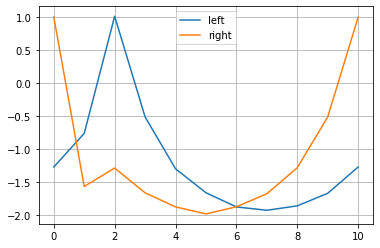

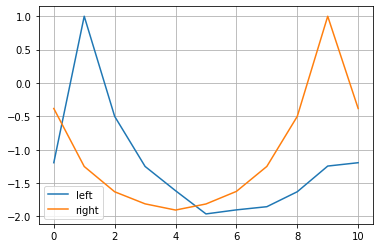

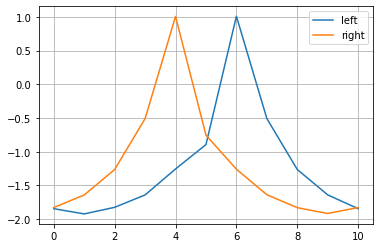

In [29]:
contexts = model.get_contexts()
for ctx in range(len(goals)):
    model.set_contexts([ctx])
    plot(model, maze_size)
model.set_contexts(contexts)

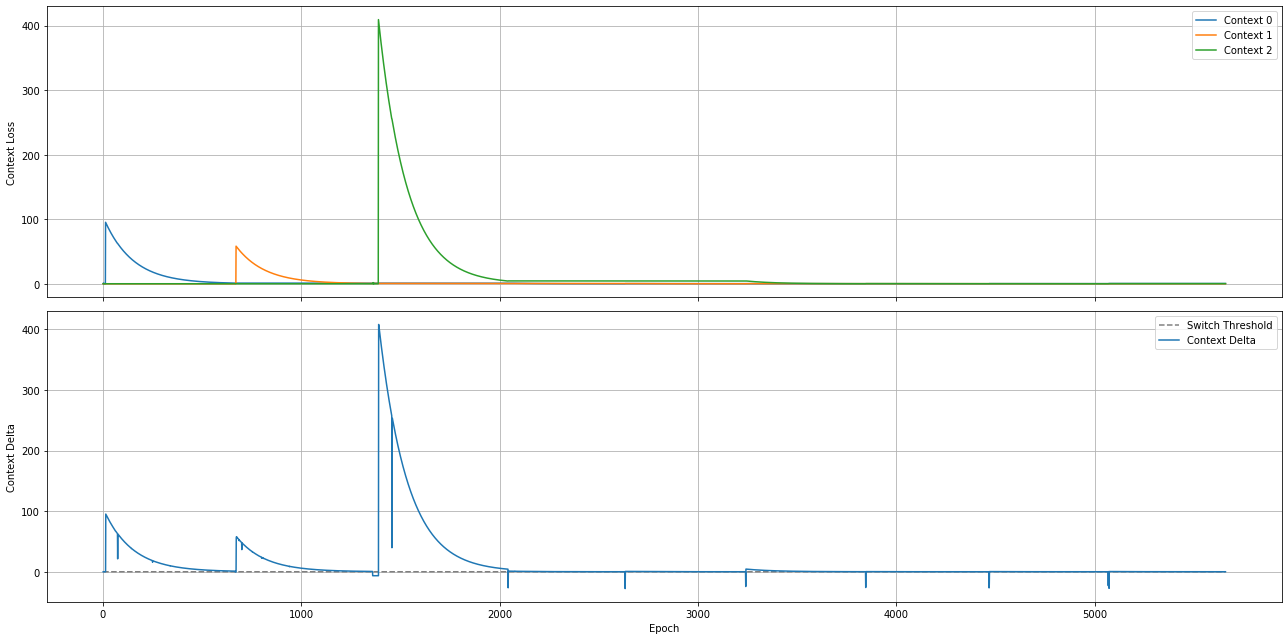

In [30]:
logger.plot(figsize=(18,9))

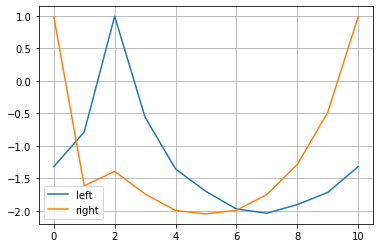

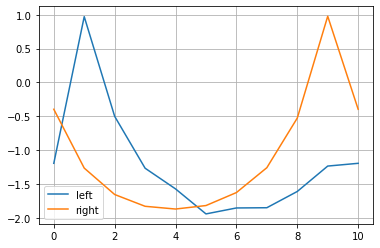

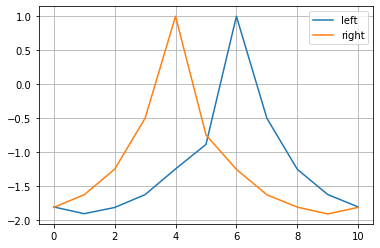

In [75]:
contexts = model.get_contexts()
for ctx in range(len(goals)):
    model.set_contexts([ctx])
    plot(model, maze_size)
model.set_contexts(contexts)

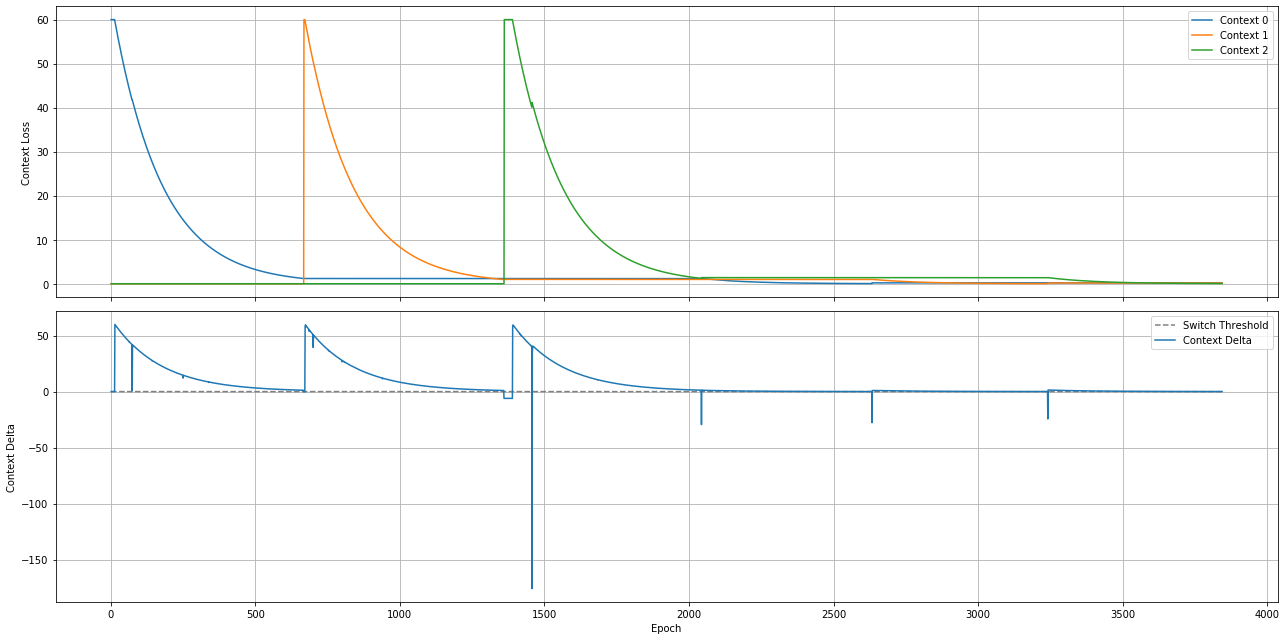

In [76]:
logger.plot(figsize=(18,9))

## Bias Weights

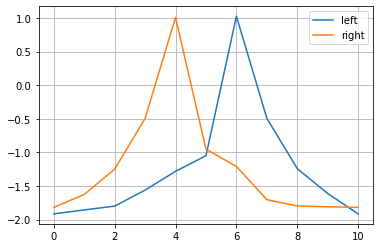

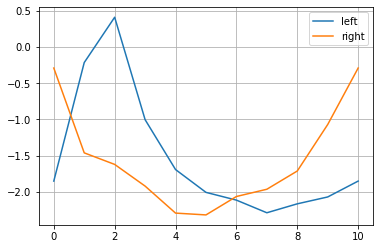

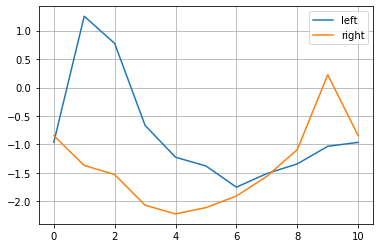

In [67]:
contexts = model.get_contexts()
for ctx in range(len(goals)):
    model.set_contexts([ctx])
    plot(model, maze_size)
model.set_contexts(contexts)

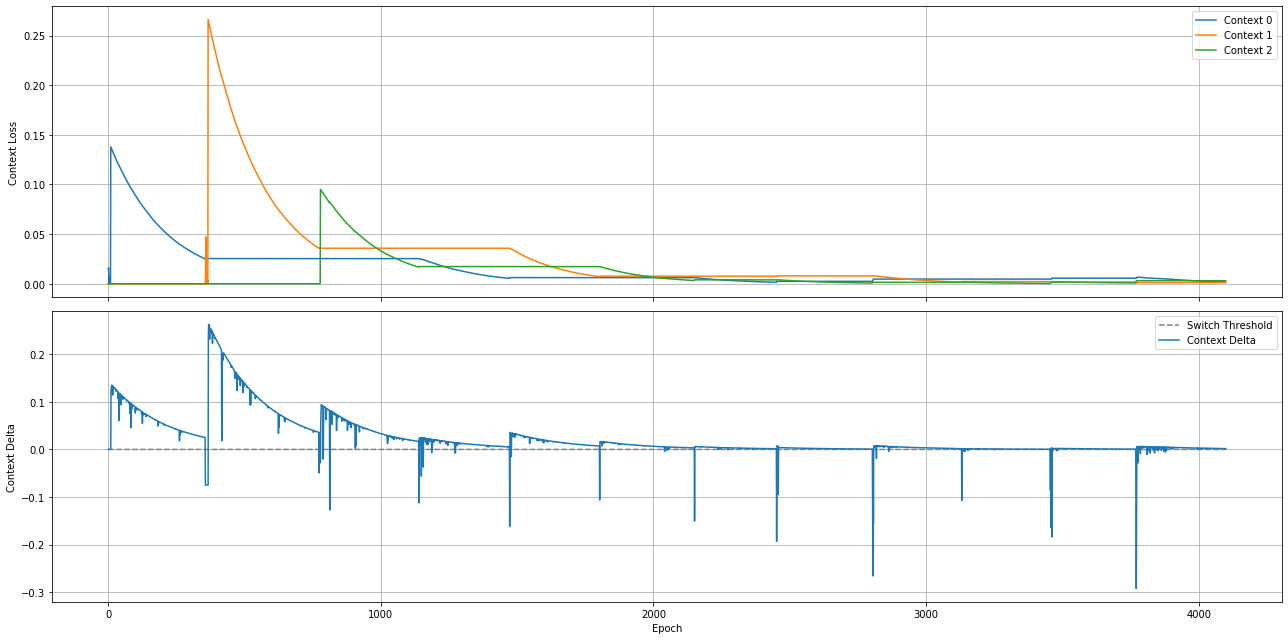

In [69]:
logger.plot(figsize=(18,9))

## Bias Weights on Last Layer

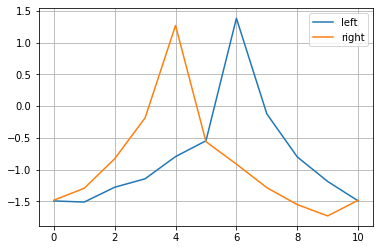

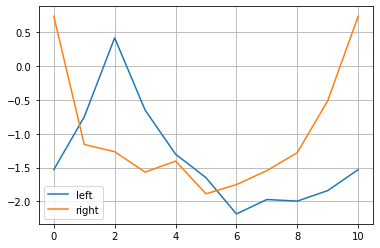

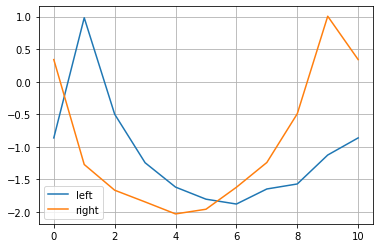

In [61]:
contexts = model.get_contexts()
for ctx in range(len(goals)):
    model.set_contexts([ctx])
    plot(model, maze_size)
model.set_contexts(contexts)

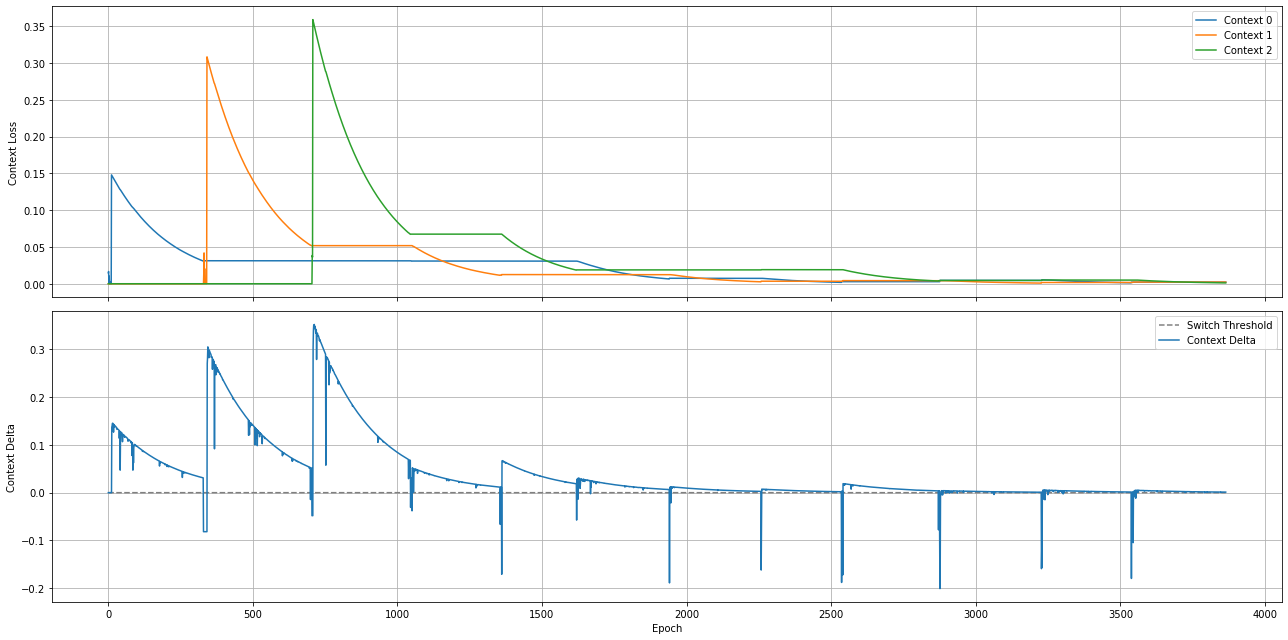

In [60]:
logger.plot(figsize=(18,9))

## No Bias Weights (Reduce Sum)

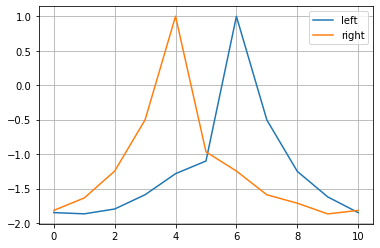

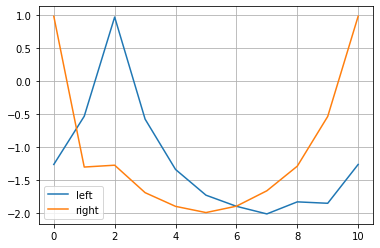

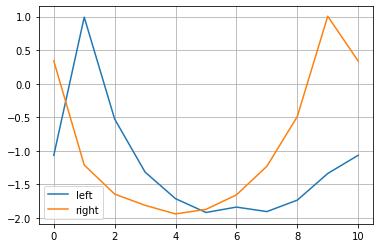

In [52]:
contexts = model.get_contexts()
for ctx in range(len(goals)):
    model.set_contexts([ctx])
    plot(model, maze_size)
model.set_contexts(contexts)

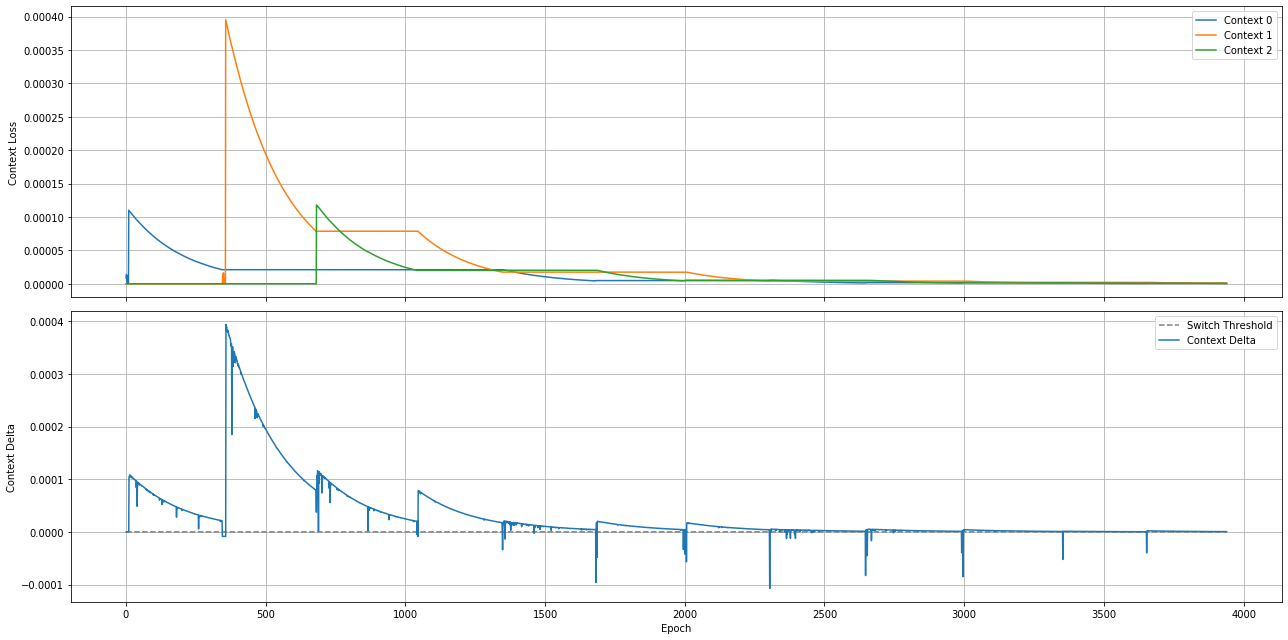

In [53]:
logger.plot(figsize=(18,9))

## No Bias Weights (Reduce Mean-squared)

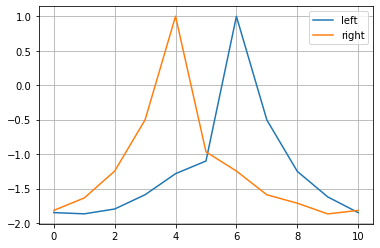

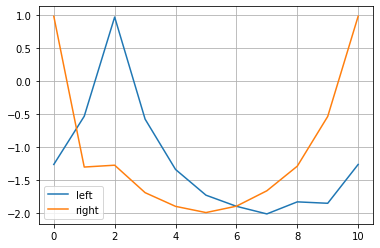

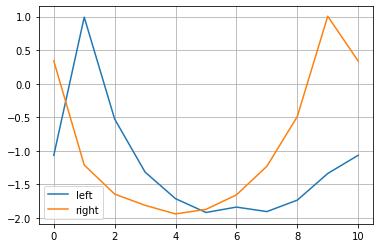

In [19]:
contexts = model.get_contexts()
for ctx in range(len(goals)):
    model.set_contexts([ctx])
    plot(model, maze_size)
model.set_contexts(contexts)

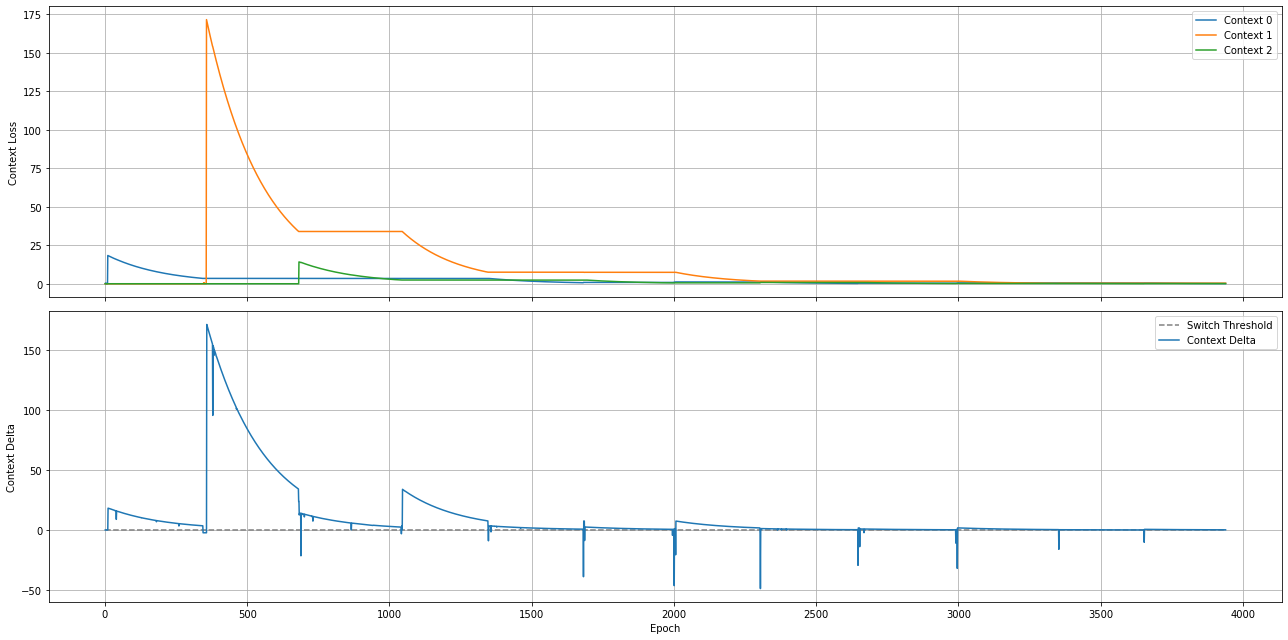

In [20]:
logger.plot(figsize=(18,9))

# Misc

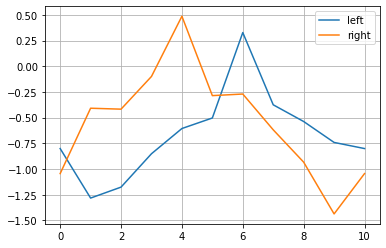

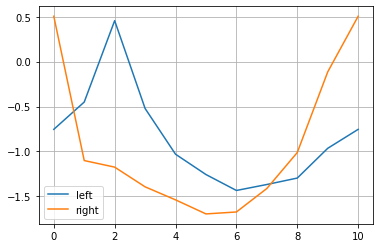

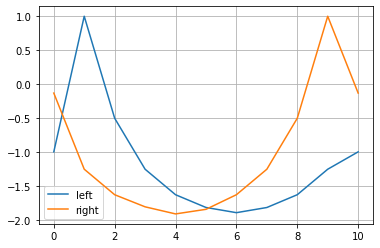

In [92]:
contexts = model.get_contexts()
for ctx in range(len(goals)):
    model.set_contexts([ctx])
    plot(model, maze_size)
model.set_contexts(contexts)

In [94]:
model2 = model # Create a backup of the model

#### Switch without Biases

In [93]:
model.backup()
opt_weights = optimizer.get_weights()

In [243]:
model.restore()
optimizer.set_weights(opt_weights)

model.layers[2].atr_model.switch_threshold = -0.08

In [244]:
q = model.predict(np.array([np.concatenate((one_hot_encode(4, 10), [0, 1]))]))
q

array([[0.9908911]], dtype=float32)

In [245]:
target = q
target[0][0] += 1.0*(-1.0 - q[0][0])
target

array([[-1.]], dtype=float32)

In [246]:
model.fit(np.array([np.concatenate((one_hot_encode(4, 10), [0, 1]))]), target, train_after_switch=False, retry_fit=False, absorb=True, verbose=Verbosity.Contexts, callbacks=callbacks)

In [286]:
np.min(list(logger.plots.values())[0][(None, 'Epoch', 'Context Delta')]['Context Delta']['y'])

-0.09379651

In [692]:
2*9.868330153040006e-08

1.9736660306080012e-07

In [ ]:
(4.874149226452573e-07, -4.042409636895172e-05)

In [632]:
float(model.layers[2].atr_model.values[0])

9.868330153040006e-08

In [508]:
list(logger.plots.values())[0][(None, 'Epoch', 'Context Delta')]['Context Delta']['y']

[<tf.Tensor: shape=(), dtype=float32, numpy=-0.000115901865>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.000115901865>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.00015456873>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.00015456873>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.00019323558>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.00019323558>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.00023190244>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.00023190244>]

In [40]:
# Back up model
weights = tf.python.keras.backend.batch_get_value(model.trainable_weights)
atr_values = model.layers[2].atr_model.values
atr_values_i = model.layers[2].atr_model.values_initialized

In [21]:
# Restore model
tf.python.keras.backend.batch_set_value(zip(model.trainable_weights, weights))
model.set_contexts([0])

[array([[-5.0968386e-02,  6.1107010e-02,  1.9934781e-02, ...,
         -7.4841082e-05, -6.3473508e-02,  1.5059054e-02],
        [-2.3364216e-02, -4.4445049e-02,  4.6402216e-02, ...,
         -3.4945570e-02,  7.4416012e-02, -1.4080182e-03],
        [ 5.7333201e-02, -2.8114319e-03, -5.7196394e-03, ...,
         -7.1774334e-02, -1.9594613e-02, -1.2864396e-02],
        ...,
        [-4.2197779e-03, -2.6979867e-02, -5.5413458e-02, ...,
         -2.9394124e-02,  2.9977441e-02,  3.3987537e-03],
        [ 4.1320108e-02,  2.5149159e-02,  7.4878886e-02, ...,
          6.4740926e-02,  2.9520467e-03,  1.7438307e-03],
        [ 5.6131706e-02, -4.7196552e-02,  6.6113546e-03, ...,
         -1.9806102e-02,  5.7845935e-02, -6.0710110e-02]], dtype=float32),
 array([[ 0.00154656],
        [-0.00864068],
        [-0.01399612],
        ...,
        [ 0.06346002],
        [-0.05274671],
        [-0.04568403]], dtype=float32)]

In [199]:
model.layers[3].atr_model.switch_threshold.assign(-0.00003)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=-2e-05>

In [209]:
tf.python.keras.backend.batch_get_value(atr_values.value())

[4.4130556e-05, 5.5896464e-05]

In [203]:
model.ctx_layers

ListWrapper([3])

## Delta Benchmark

### Maze Settings

In [406]:
delta_tuples = []
for seed in range(1): 
    set_seed(seed)

    # Maze Settings
    maze_size = 10
    goals = (5, 0)
    
    # Optimizer
    optimizer = tf.keras.optimizers.SGD(1e-1)

    # Hyperparameters
    maze_size = 10
    hrr_size = 1024
    num_contexts = len(goals)
    switch_threshold = -0.06

    # Model Architecture
    inp = Input((maze_size + 2,))
    x = Dense(hrr_size, activation="relu", use_bias=True)(inp)
    x = Context(num_contexts, TdErrorSwitch(0.003, switch_threshold, init_multiplier=25))(x)
    x = Dense(1, activation="linear", use_bias=True)(x)

    # Create the model
    model = NTaskModel(inputs=inp, outputs=x)

    # Compile the model
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizer)
    
    learn_rate = 1.0
    discount_factor = 0.5
    epsilon = 0.1

    move_limit = 30

    # episodes = 300
    logger = AtrLogger(track_epochs_internally=True)
    callbacks = [logger]

    train(model, maze_size, goals, move_limit, 1000, learn_rate, discount_factor, epsilon, switch_freq=500, auto_switch=False, callbacks=callbacks)
    
    # Find the largest delta value before the context switch
    largest_delta = np.min(list(logger.plots.values())[0][(None, 'Epoch', 'Context Delta')]['Context Delta']['y'])
    
    # Set the threshold
    model.layers[2].atr_model.switch_threshold = largest_delta
    
    # Reward the model with a -1 to force a context switch
    q = model.predict(np.array([np.concatenate((one_hot_encode(4, 10), [0, 1]))]))
    target = q
    target[0][0] += 1.0*(-1.0 - q[0][0])
    model.fit(np.array([np.concatenate((one_hot_encode(4, 10), [0, 1]))]), target, train_after_switch=False, retry_fit=False, absorb=True, verbose=Verbosity.Contexts, callbacks=callbacks)
    
    switch_delta = float(list(logger.plots.values())[0][(None, 'Epoch', 'Context Delta')]['Context Delta']['y'][-1])
    
    delta_tuples.append((largest_delta, switch_delta))

Switched to goal: 5 at epoch 1
Switched to goal: 0 at epoch 251
Switched to goal: 5 at epoch 501
Switched to goal: 0 at epoch 751
Switched to goal: 5 at epoch 1
Switched to goal: 0 at epoch 251
Switched to goal: 5 at epoch 501
Switched to goal: 0 at epoch 751
Switched to goal: 5 at epoch 1
Switched to goal: 0 at epoch 251
Switched to goal: 5 at epoch 501
Switched to goal: 0 at epoch 751
Switched to goal: 5 at epoch 1
Switched to goal: 0 at epoch 251
Switched to goal: 5 at epoch 501
Switched to goal: 0 at epoch 751
Switched to goal: 5 at epoch 1
Switched to goal: 0 at epoch 251
Switched to goal: 5 at epoch 501
Switched to goal: 0 at epoch 751
Switched to goal: 5 at epoch 1
Switched to goal: 0 at epoch 251
Switched to goal: 5 at epoch 501
Switched to goal: 0 at epoch 751
Switched to goal: 5 at epoch 1
Switched to goal: 0 at epoch 251
Switched to goal: 5 at epoch 501
Switched to goal: 0 at epoch 751
Switched to goal: 5 at epoch 1
Switched to goal: 0 at epoch 251
Switched to goal: 5 at epo

In [407]:
np.min(np.array(delta_tuples)[:,0:]), np.max(np.array(delta_tuples)[:,0:])

(-0.2566053569316864, -0.019843995571136475)

In [408]:
np.min(np.array(delta_tuples)[:,1:]), np.max(np.array(delta_tuples)[:,1:])

(-0.025254910811781883, -0.019843995571136475)

In [322]:
delta_tuples_0_01

[(-0.14256394, -0.06992161273956299),
 (-0.09379651, -0.06830572336912155),
 (-0.048413616, -0.06872863322496414),
 (-0.15951696, -0.06569697707891464),
 (-0.08119399, -0.0706196129322052),
 (-0.09724042, -0.06807347387075424),
 (-0.1317514, -0.06919786334037781),
 (-0.15436135, -0.06644468009471893),
 (-0.111151114, -0.06475377827882767),
 (-0.10388311, -0.06915304809808731),
 (-0.15404265, -0.06900627911090851),
 (-0.12501973, -0.06842521578073502),
 (-0.109304346, -0.0640069842338562),
 (-0.108204976, -0.06824398785829544),
 (-0.046263825, -0.06840844452381134),
 (-0.14323987, -0.07276278734207153),
 (-0.10698693, -0.06807836145162582),
 (-0.13974692, -0.06484397500753403),
 (-0.028206872, -0.07090970128774643),
 (-0.118898965, -0.06891176849603653),
 (-0.13067725, -0.06549433618783951),
 (-0.152709, -0.06866787374019623),
 (-0.14804384, -0.07094371318817139),
 (-0.13765639, -0.06730590015649796),
 (-0.14856854, -0.06537089496850967),
 (-0.14141493, -0.06712498515844345),
 (-0.15020

#### Switch with Biases [SGD(1e-1)]

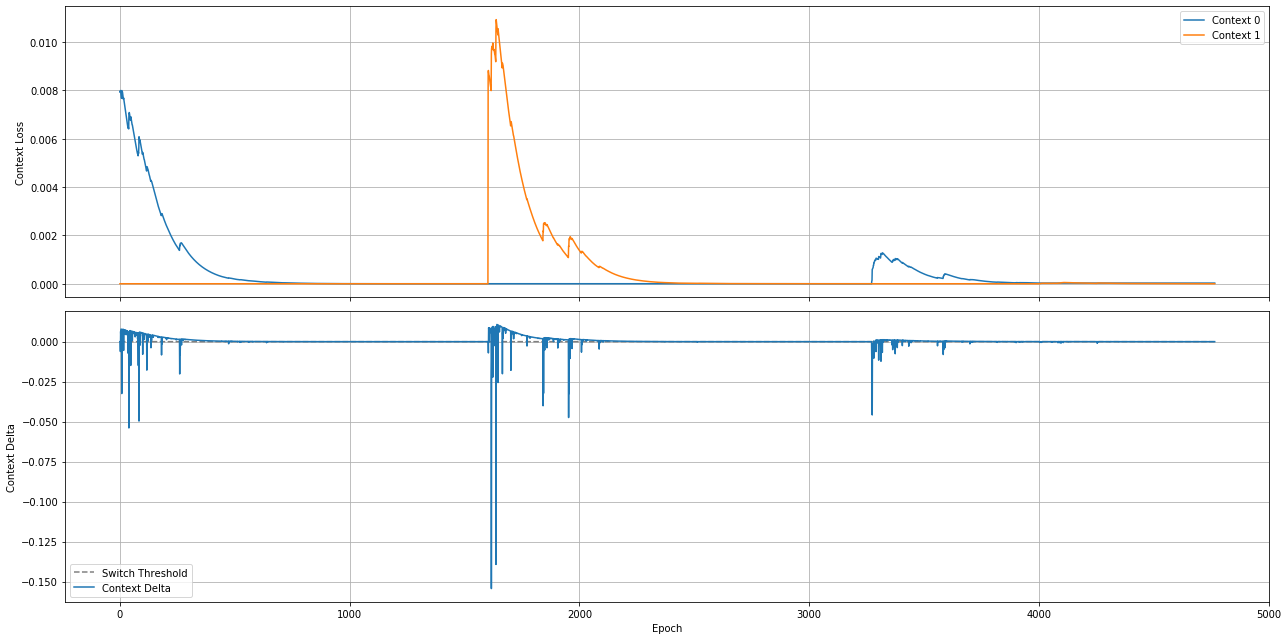

In [385]:
logger.plot(figsize=(18,9))

#### With Bias Weights [Adam(1e-3)]

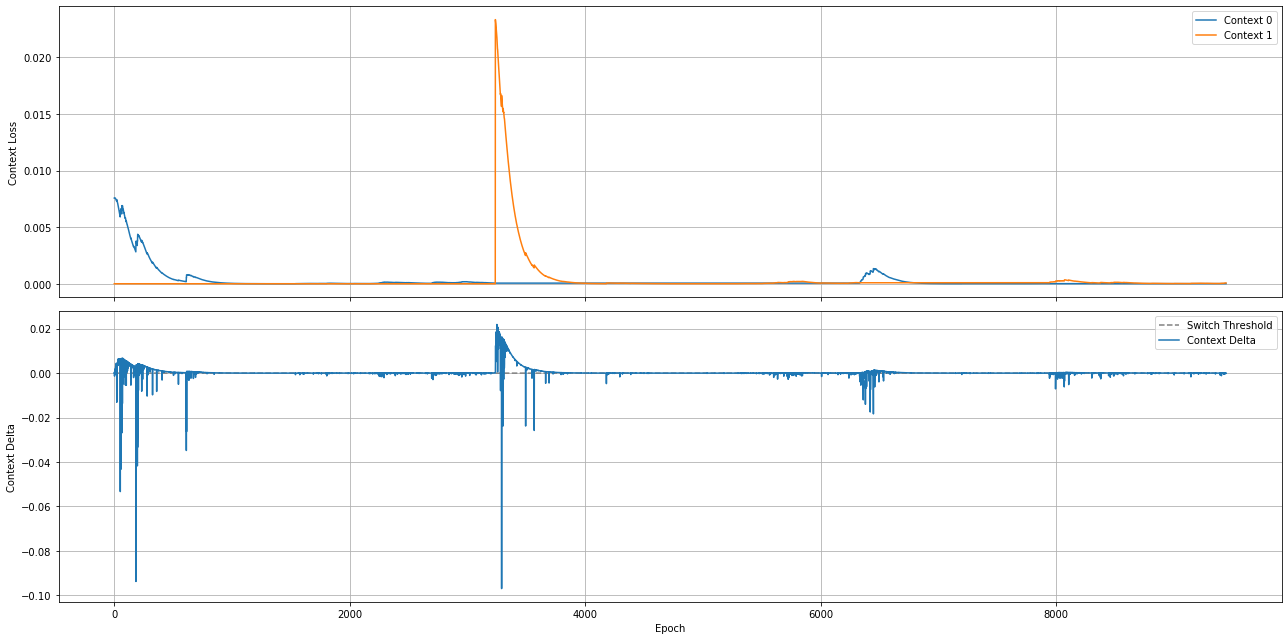

In [130]:
logger.plot(figsize=(18,9))

#### Without Bias Weights [Adam(1e-3)]

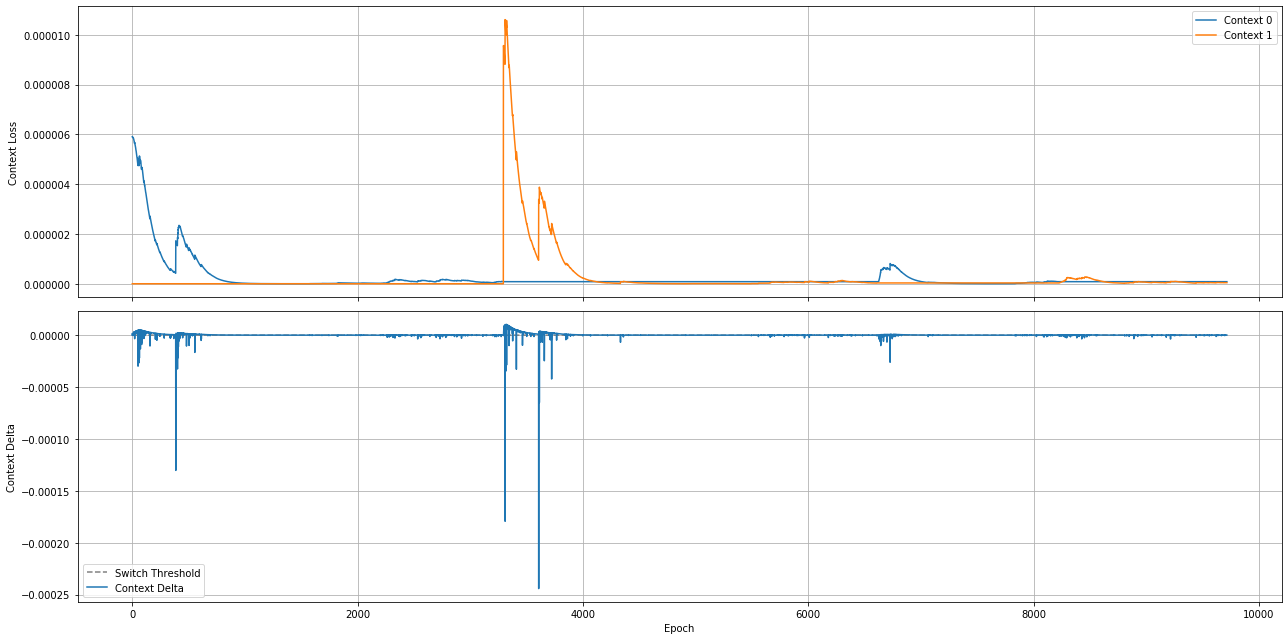

In [121]:
logger.plot(figsize=(18,9))